# Assignment 3
# Rishika Tibrewal (MDS202135)

## Importing Libraries

In [ ]:
# !pip install fasttext-langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# ! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from random import randint
from zipfile import ZipFile
import re, warnings, nltk,tqdm
import json,contractions,keras,gc
import matplotlib.pyplot as plt
from ftlangdetect import detect
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding,LSTM,Dense,Dropout,Bidirectional

from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('omw-1.4')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Importing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def unzip_read_and_extract(filename:str, count):
    data = []
    with ZipFile(filename, "r") as z:
        for filename in z.namelist():
            with z.open(filename) as f:
                try:
                    paper_content = json.load(f)
                    abstract = ""
                    if 'abstract' in paper_content :
                        for bt in paper_content['abstract']:
                            abstract += bt ['text']
                    content = (abstract + '\n').lower()
                    data.append(content)
                except ValueError as e:
                    print("Not a valid JSON")
            if (len(data) == count):
                break
    return data

In [ ]:
data = unzip_read_and_extract("/content/drive/MyDrive/pdf_json.zip",500)

Not a valid JSON


In [ ]:
data[3]

'impact du sars-cov2 sur la structuration de la prise en charge du cancer : exemple de la tenue des rcp de cancérologie en occitanie, bulletin du cancer (2020), doi: https://doi.\n'

## Preprocessing Data

In [ ]:
# Function for text preprocessing

def preprocessing(text):

  if "\n" in text:
    text = text.replace("\n","")
    
  lang=detect(text,low_memory=False)

  if lang["lang"]=="en":

    # Fixing contractions
    text = contractions.fix(text)

    # Converting abstracts to lower case
    text=text.lower()

    # Removing citations
    cit_pattern = re.compile(r'\[\d+(,[ \t]*\d+)*\]')
    text = cit_pattern.sub(r'', text)

    # Removing URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)

    # Removing email
    email_pattern = re.compile(r'''([-!#-'*+/-9=?A-Z^-~]+(\.[-!#-'*+/-9=?A-Z^-~]+)*|"([]!#-[^-~ \t]|(\\[\t -~]))+")@([-!#-'*+/-9=?A-Z^-~]+(\.[-!#-'*+/-9=?A-Z^-~]+)*|\[[\t -Z^-~]*])''')
    text = email_pattern.sub(r'', text)

    # Removing punctuations
    punct_pattern = re.compile(r'[^\w\s]')
    text= punct_pattern.sub(r'', text)

    # Replacing multiple occurences of space with a single space
    text=re.sub("\s*\s"," ",text)

    # Tokenizing text
    words=text.split(" ")
    words=[i for i in words if i!='']

    return words

token is a list of lists, where each list consists of tokens in an abstract

In [ ]:
token=list(map(preprocessing,data))
token=list(filter(lambda value: value is not None, token))
len(token)

492

Combining tokens from all abstracts

In [ ]:
tokens=[]
for i in token:
  for j in i:
    tokens.append(j)

In [ ]:
len(tokens)

70644

Count of unique tokens

In [ ]:
len(set(tokens))

10463

## Creating Word Sequences

In [ ]:
# Creating sequences of words of length 30, i.e., for every sequence of 30 words, the 31st word is the output at that timestep
word_seq=[]

train_len=30 + 1

for i in range(0,len(tokens)-train_len+1):
  w=tokens[i:i+train_len]
  word_seq.append(w)

In [ ]:
len(word_seq[0])

31

In [ ]:
print(word_seq[0])

['the', 'role', 'of', 'noninvasive', 'ventilation', 'niv', 'in', 'acute', 'respiratory', 'failure', 'caused', 'by', 'viral', 'pneumonia', 'remains', 'controversial', 'our', 'objective', 'was', 'to', 'evaluate', 'the', 'use', 'of', 'niv', 'in', 'a', 'cohort', 'of', 'h1n1v', 'pneumonia']


In [ ]:
del token,w,data,i,j
gc.collect()

192

## Implementing Encoder

In [ ]:
tokenizer=Tokenizer()

# Fitting the object on the word sequences
tokenizer.fit_on_texts(word_seq)

# Creating a matrix of the encoded word sequences
seq=np.array(tokenizer.texts_to_sequences(word_seq))
seq

array([[    1,   166,     2, ...,     2, 10461,   310],
       [  166,     2,  2785, ..., 10461,   310,  2786],
       [    2,  2785,   445, ...,   310,  2786,     3],
       ...,
       [   89,   286,     3, ...,     2,  1197,    18],
       [  286,     3,  1879, ...,  1197,    18,    40],
       [    3,  1879,   680, ...,    18,    40,   583]])

In [ ]:
vocab_len=len(tokenizer.word_counts)
print("Length of vocabulary is ",vocab_len)

Length of vocabulary is  10463


In [ ]:
# Taking the first 30 words of each sequence as training set
X_train=seq[:,:-1]

# Taking the last word of each sequence as the target
y_train=seq[:,-1]

# Converting the y_train to categorical, and taking all the words in vocab plus one as classes 
y_train=to_categorical(y_train,num_classes=vocab_len+1)

In [ ]:
# Creating a model with 2 Bidirectional LSTM layers

def create_model(vocabulary_size, seq_len):
    model = Sequential()
    model.add(Embedding(vocabulary_size, 30, input_length=seq_len))
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    model.add(Dropout(0.8))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(vocabulary_size, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    model.summary()
    
    return model

In [ ]:
model=create_model(vocab_len+1,30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 30)            313920    
                                                                 
 bidirectional (Bidirectiona  (None, 30, 300)          217200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 300)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              541200    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 150)               45150     
                                                                 
 dense_1 (Dense)             (None, 10464)             1

In [ ]:
del seq,word_seq
gc.collect()

13345

Fitting the model

In [ ]:
history=model.fit(X_train, y_train, batch_size=128, epochs=200,verbose=1)

Epoch 1/200
552/552 [==============================] - 107s 167ms/step - loss: 7.4833 - accuracy: 0.0583
Epoch 2/200
552/552 [==============================] - 34s 62ms/step - loss: 7.0539 - accuracy: 0.0780
Epoch 3/200
552/552 [==============================] - 24s 44ms/step - loss: 6.8652 - accuracy: 0.0886
Epoch 4/200
552/552 [==============================] - 26s 48ms/step - loss: 6.7238 - accuracy: 0.0948
Epoch 5/200
552/552 [==============================] - 23s 41ms/step - loss: 6.5872 - accuracy: 0.1021
Epoch 6/200
552/552 [==============================] - 23s 42ms/step - loss: 6.4465 - accuracy: 0.1108
Epoch 7/200
552/552 [==============================] - 26s 47ms/step - loss: 6.3175 - accuracy: 0.1180
Epoch 8/200
552/552 [==============================] - 28s 51ms/step - loss: 6.1946 - accuracy: 0.1248
Epoch 9/200
552/552 [==============================] - 21s 37ms/step - loss: 6.0827 - accuracy: 0.1312
Epoch 10/200
552/552 [==============================] - 22s 40ms/step -

Plot of loss vs epoch

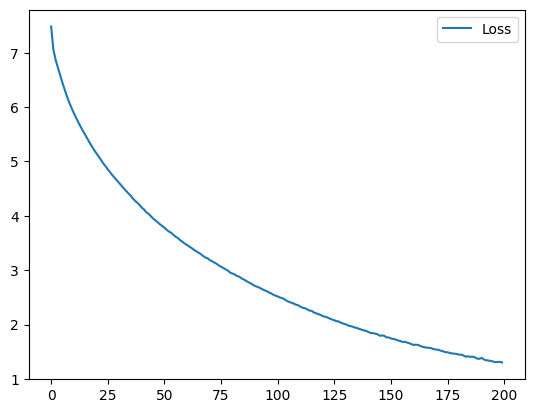

In [ ]:
plt.plot(history.history["loss"],label="Loss")
plt.legend()
plt.show()

Plot of accuracy vs epoch

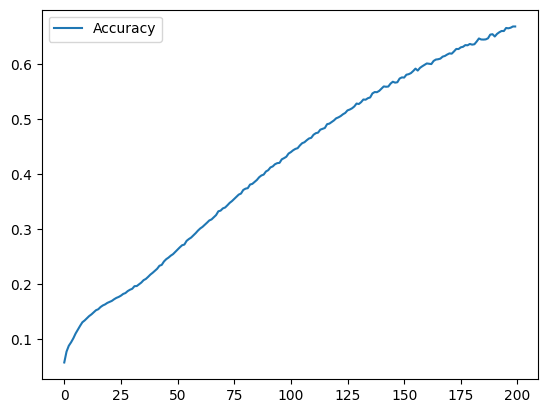

In [ ]:
plt.plot(history.history["accuracy"],label="Accuracy")
plt.legend()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/abstract_model.h5")

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/abstract_model.h5')

## Implementing Decoder

In [ ]:
#Generate new text
def generate_text(model, tokenizer, seq_len, sample_text, abstract_len):
    '''
    INPUTS:
    model : model that was trained on text data
    tokenizer : tokenizer that was fit on text data
    seq_len : length of training sequence
    sample_text : raw string text to serve as the seed
    abstract_len : number of words to be generated by model
    '''
    
    # Final Output
    output_text = []
    
    # Intial Seed Sequence
    input_text = sample_text
    
    # Create abstract_len number of words
    for i in range(abstract_len):
        
        # Take the input text string and encode it to a sequence
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        
        # Pad sequences to our trained rate
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
        
        # Predict Class Probabilities for each word and take one with highest probability
        pred_word_ind = np.argmax(model.predict(pad_encoded, verbose=0)[0])
        
        # Grab word from the index
        pred_word = tokenizer.index_word[pred_word_ind] 
        
        # Update the sequence of input text (shifting one over with the new word)
        input_text += ' ' + pred_word
        
        # Appending the predicted word to the abstract with every iteration
        output_text.append(pred_word)
        
    # Joining words to generate a sentence
    return ' '.join(output_text)
     

In [ ]:
sents=[]
test_data = unzip_read_and_extract("/content/drive/MyDrive/pdf_json.zip",600)

Not a valid JSON


In [ ]:
token=list(map(preprocessing,test_data[-20:]))
token=list(filter(lambda value: value is not None, token))

In [ ]:
test_sents=[" ".join(i) for i in token[:10]]

In [ ]:
test_sents[0]

'approved the manuscript and agreed with its submission also all authors contributed equally to this study in conceptualization data curation formal analysis methodology validation writing the original draft and writing the reviewbrazil is one of the epicenters of the covid19 pandemic and has reported 5113628 cases and 150998 deaths by the disease comparing the deaths by natural causes expected and the excess mortality rate there is a 22 increase in deaths mainly of male patients and individuals over 60 years old'

Picking up abstracts from test_sents and trying to generate a new abstract

In [ ]:
for sent in test_sents:
  out=generate_text(model,tokenizer,30,seed_text=sent,num_gen_words=50)

  print("Actual sentence ---",sent)
  print("Generated sentence ---",out)
  print("\n")
  print("*******************************************************************")
  print("\n")

Actual sentence --- approved the manuscript and agreed with its submission also all authors contributed equally to this study in conceptualization data curation formal analysis methodology validation writing the original draft and writing the reviewbrazil is one of the epicenters of the covid19 pandemic and has reported 5113628 cases and 150998 deaths by the disease comparing the deaths by natural causes expected and the excess mortality rate there is a 22 increase in deaths mainly of male patients and individuals over 60 years old
Generated sentence --- affect the identification of these b cell interactions including whom it is presently massive years as a definite history of exposure to the further observations that one of the face of a long framework to gain because field one for the ongoing covid19 pandemic probably and an individual surgical before


*******************************************************************


Actual sentence --- the novel severe acute respiratory syndrom

The generated sentences don't make sense entirely, but the phrases are grammatically correct. One reason for such results could be less data, or less number of epochs and adequate layers.